Исходный многочлен:


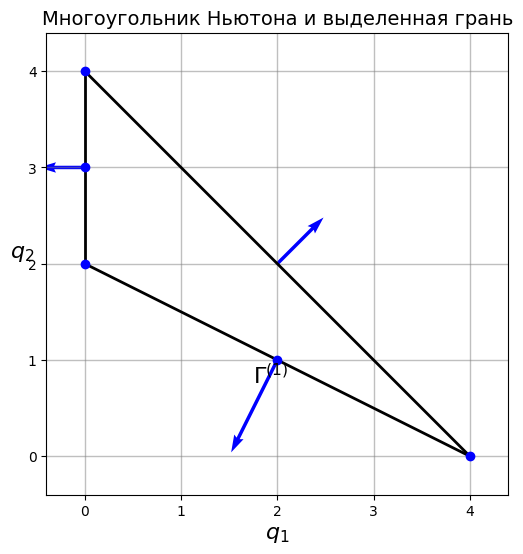


Укороченный многочлен, соответствующий выделенной грани:



Начальные члены разложений y(x):


In [22]:
# -------------------------------------------
# Часть 1. Начальные члены разложений ветвей
# -------------------------------------------

import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

from sympy import symbols, solve
from pglib.pgutils import SCH, Norm2Dlst, GetTrunc
from pglib.pgplot import NPimage, AddEdgeLabel 

from IPython.display import display

sym.init_printing()

# -----------------------------------------------------------
# 1. Определение исходного многочлена
# -----------------------------------------------------------

x, y = symbols("x y", real=True)
f = 2*x**4 + y**4 - 3*x**2*y - 2*y**3 + y**2

print("Исходный многочлен:")
display(f)

# -----------------------------------------------------------
# 2. Построение носителя и многоугольника Ньютона
# -----------------------------------------------------------

support, newton_poly = SCH(f, [x, y])
normals = Norm2Dlst(newton_poly)

# Подходящие рёбра — те, у которых внешняя нормаль отрицательна по обеим компонентам
candidate_edges = [i for i, n in enumerate(normals) if n[0] < 0 and n[1] < 0]
selected_edge = candidate_edges[0]

# -----------------------------------------------------------
# 2A. Визуализация многоугольника Ньютона
# -----------------------------------------------------------

ax = NPimage(newton_poly, np.array(support), withNormals=True)

AddEdgeLabel(
    ax,
    np.array(support),
    newton_poly,
    normals,
    selected_edge,
    r"$\Gamma^{(1)}$",
    shift=0.25
)

plt.title("Многоугольник Ньютона и выделенная грань", fontsize=14)
plt.show()

# -----------------------------------------------------------
# 3. Укороченный многочлен по выбранной грани
# -----------------------------------------------------------

trunc_poly = GetTrunc(f, newton_poly, selected_edge).factor()

print("\nУкороченный многочлен, соответствующий выделенной грани:")
display(trunc_poly)

# -----------------------------------------------------------
# 4. Начальные члены разложений (ветви)
# -----------------------------------------------------------

initial_solutions = solve(sym.Eq(trunc_poly, 0), y, dict=True)

print("\nНачальные члены разложений y(x):")
for sol in initial_solutions:
    display(sol[y])

In [23]:
# -----------------------------------------------------------
# Часть 2. Уточнение вещественных ветвей
# -----------------------------------------------------------

import sympy as sym
import numpy as np
from sympy import symbols, solve, expand
from pglib.pgutils import SCH, Norm2Dlst, GetTrunc
from IPython.display import display

sym.init_printing()

# -----------------------------------------------------------
# 1. Исходные данные и найденные ранее начальные ветви
# -----------------------------------------------------------

x, y, z = symbols("x y z", real=True)

f = 2*x**4 + y**4 - 3*x**2*y - 2*y**3 + y**2

# Начальные ветви из Часть 1:
initial_roots = [x**2, 2*x**2]    # y1 = x^2, y2 = 2x^2

# -----------------------------------------------------------
# Функция уточнения разложения для одной ветви
# -----------------------------------------------------------

def refine_branch(f, y0):
    """
    Проводит замену:
        y = y0(x) * (1 + z)
    строит новый многоугольник Ньютона для f(x, z),
    находит укороченный многочлен и решение для z.
    Возвращает уточнённое разложение y(x) до следующего порядка.
    """

    # Шаг 1. Подстановка y = y0*(1+z)
    subs_rule = {y: y0*(1 + z)}
    g = expand(f.subs(subs_rule))

    # Шаг 2. Многоугольник Ньютона в переменных (x, z)
    support, poly = SCH(g, [x, z])
    normals = Norm2Dlst(poly)

    # Выбираем грань с отрицательной нормалью
    edge_candidates = [i for i, n in enumerate(normals) if n[0] < 0 and n[1] < 0]
    edge = edge_candidates[0]

    # Шаг 3. Укороченный многочлен по новой грани
    g_trunc = expand(GetTrunc(g, poly, edge, [x, z]))

    # Шаг 4. Решение укороченного уравнения g_trunc = 0 относительно z
    z_solution = solve(sym.Eq(g_trunc, 0), z, dict=True)[0][z]

    # Шаг 5. Полное уточнённое разложение y(x)
    refined_y = expand(y0 * (1 + z_solution))

    return refined_y, g_trunc, support, poly


# -----------------------------------------------------------
# 2. Уточнение двух вещественных ветвей
# -----------------------------------------------------------

refined_results = []

for idx, root in enumerate(initial_roots, start=1):
    refined_y, g_trunc, support, poly = refine_branch(f, root)

    print(f"\n--- Ветвь {idx}: начальный член y0(x) = {root} ---")
    print("Укороченное уравнение для z(x):")
    display(g_trunc)

    print("Следующий член разложения:")
    display(refined_y)

    refined_results.append(refined_y)

# -----------------------------------------------------------
# Уточнённые разложения:
# y1(x) = x^2 - 2x^4
# y2(x) = 2x^2 + 16x^4
# -----------------------------------------------------------


--- Ветвь 1: начальный член y0(x) = x**2 ---
Укороченное уравнение для z(x):


Следующий член разложения:



--- Ветвь 2: начальный член y0(x) = 2*x**2 ---
Укороченное уравнение для z(x):


Следующий член разложения:


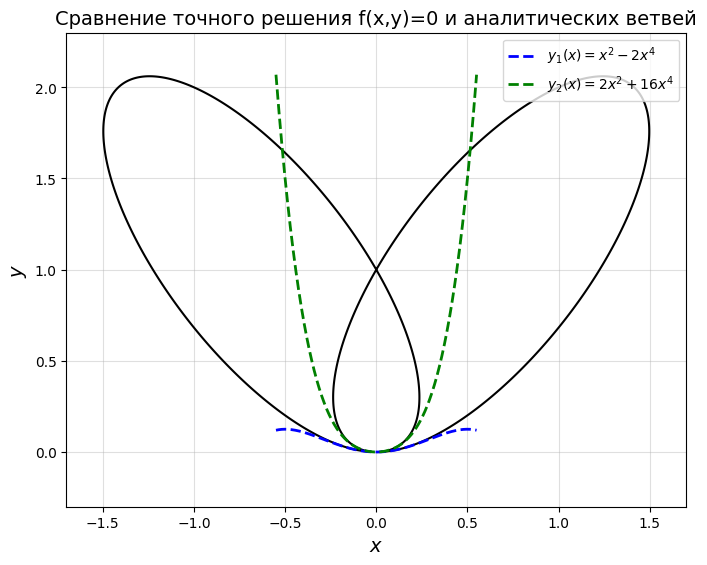

In [24]:
# -----------------------------------------------------------
# Часть 3. Графическое сравнение точного решения и разложений
# -----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from sympy import symbols, lambdify
from IPython.display import display

sym.init_printing()

# -----------------------------------------------------------
# 1. Исходный многочлен и уточнённые ветви из части 2
# -----------------------------------------------------------

x, y = symbols("x y", real=True)
f = 2*x**4 + y**4 - 3*x**2*y - 2*y**3 + y**2

# Уточнённые ветви, полученные в части 2
y1 = x**2 - 2*x**4
y2 = 2*x**2 + 16*x**4

# -----------------------------------------------------------
# 2. Численное вычисление контуров f(x,y)=0
# -----------------------------------------------------------

vf = lambdify((x, y), f, "numpy")
y1_func = lambdify(x, y1, "numpy")
y2_func = lambdify(x, y2, "numpy")

# Диапазон для построения
xmin, xmax = -1.7, 1.7
ymin, ymax = -0.3, 2.3
N = 1200

x_vals = np.linspace(xmin, xmax, N)
y_vals = np.linspace(ymin, ymax, N)
X, Y = np.meshgrid(x_vals, y_vals)

Z = vf(X, Y)

# Окно для построения ветвей
x_local = np.linspace(-0.55, 0.55, 800)
y1_vals = y1_func(x_local)
y2_vals = y2_func(x_local)

# -----------------------------------------------------------
# 3. Визуализация
# -----------------------------------------------------------

plt.figure(figsize=(8, 8))
plt.title("Сравнение точного решения f(x,y)=0 и аналитических ветвей", fontsize=14)

# Контур точного решения
plt.contour(
    X, Y, Z,
    levels=[0],
    colors='black',
    linewidths=1.5
)

# Аналитические ветви
plt.plot(x_local, y1_vals, 'b--', linewidth=2, label=r"$y_1(x)=x^2-2x^4$")
plt.plot(x_local, y2_vals, 'g--', linewidth=2, label=r"$y_2(x)=2x^2+16x^4$")

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.grid(True, alpha=0.4)
plt.legend(loc="upper right")
plt.gca().set_aspect("equal")

plt.show()

In [25]:
# -----------------------------------------------------------
# Часть 4. Степенное преобразование и повторное получение ветвей
# -----------------------------------------------------------

import sympy as sym
from sympy import symbols, solve, Matrix, expand
from pglib.pgutils import Norm2Dlst
from pglib.pgpowertransform import UniMod1, PowTrans
from pglib.pgutils import SCH
from IPython.display import display

sym.init_printing()

# -----------------------------------------------------------
# 1. Исходный многочлен
# -----------------------------------------------------------

x, y = symbols("x y", real=True)
f = 2*x**4 + y**4 - 3*x**2*y - 2*y**3 + y**2

# -----------------------------------------------------------
# 2. Построение многоугольника Ньютона и нормалей (как в части 1)
# -----------------------------------------------------------

support, poly = SCH(f, [x, y])
normals = Norm2Dlst(poly)

# Выбор грани, использованной ранее
edge_candidates = [i for i, n in enumerate(normals) if n[0] < 0 and n[1] < 0]
selected_edge = edge_candidates[0]
normal = normals[selected_edge]

print("Выбранная грань:", selected_edge)
print("Её нормаль:", normal)

# -----------------------------------------------------------
# 3. Построение унимодулярной матрицы преобразования
# -----------------------------------------------------------

abs_norm = (abs(normal[0]), abs(normal[1]))
alpha = UniMod1(*abs_norm)
alpha_inv = alpha.inv()

print("\nМатрица степенного преобразования α:")
display(alpha)

print("Обратная матрица α^{-1}:")
display(alpha_inv)

# -----------------------------------------------------------
# 4. Введение новых переменных и преобразование многочлена
# -----------------------------------------------------------

xi, eta = symbols("xi eta", real=True)

# Преобразование задаётся матрицей α^{-1}
sub_map = PowTrans(alpha_inv, (x, y), (xi, eta))

# Подстановка в укороченный многочлен (из части 1)
# Укороченный многочлен из части 1 имел вид:
# trunc_poly = y*(y - x**2)*(y - 2*x**2)
trunc_poly = y*(y - x**2)*(y - 2*x**2)

# Преобразуем его
g_new = expand(trunc_poly.subs(sub_map))

print("\nПреобразованное укороченное уравнение:")
display(g_new.factor())

# -----------------------------------------------------------
# 5. Решение преобразованного уравнения
# -----------------------------------------------------------

# Ищем η из преобразованного уравнения
solutions_new = solve(sym.Eq(g_new, 0), eta, dict=True)

print("\nРешения преобразованного укороченного уравнения:")
for s in solutions_new:
    display(s[eta])

# -----------------------------------------------------------
# 6. Обратная подстановка для восстановления y(x)
# -----------------------------------------------------------

print("\nВосстановление исходных ветвей:")

restored_branches = []
for sol in solutions_new:
    back_sub = y.subs(sub_map).subs(eta, sol[eta])
    simplified = sym.simplify(back_sub)
    restored_branches.append(simplified)
    display(simplified)

# Итоговые ветви:
# y = x^2,  y = 2*x^2

Выбранная грань: 0
Её нормаль: [-1 -2]

Матрица степенного преобразования α:


⎡1   0⎤
⎢     ⎥
⎣-2  1⎦

Обратная матрица α^{-1}:


⎡1  0⎤
⎢    ⎥
⎣2  1⎦


Преобразованное укороченное уравнение:



Решения преобразованного укороченного уравнения:



Восстановление исходных ветвей:


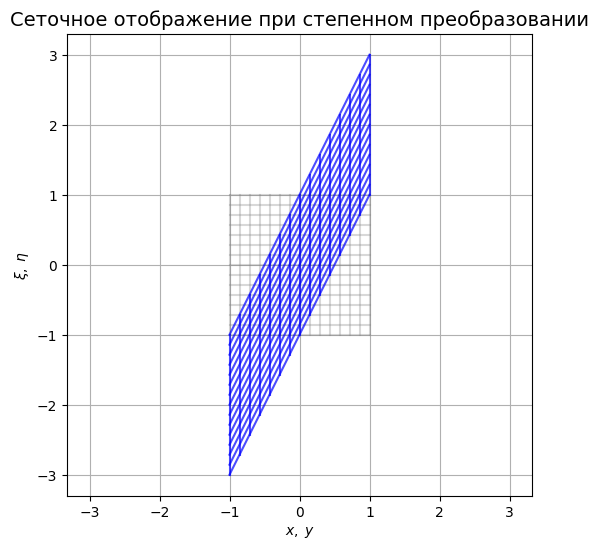

In [26]:
# -----------------------------------------------------------
# Доп. график 1: отображение степенного преобразования
# -----------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Возьмём набор точек сетки в (x,y)
xx = np.linspace(-1, 1, 15)
yy = np.linspace(-1, 1, 15)
Xg, Yg = np.meshgrid(xx, yy)

# Преобразуем в (ξ, η) через alpha^{-1}
A_inv = np.array(alpha_inv.tolist(), dtype=float)

Xi = A_inv[0,0]*Xg + A_inv[0,1]*Yg
Eta = A_inv[1,0]*Xg + A_inv[1,1]*Yg

plt.figure(figsize=(6,6))
plt.plot(Xg, Yg, color="gray", alpha=0.3)
plt.plot(Xg.T, Yg.T, color="gray", alpha=0.3)
plt.plot(Xi, Eta, color="blue", alpha=0.7)
plt.plot(Xi.T, Eta.T, color="blue", alpha=0.7)

plt.title("Сеточное отображение при степенном преобразовании", fontsize=14)
plt.xlabel(r"$x,\; y$")
plt.ylabel(r"$\xi,\; \eta$")
plt.axis("equal")
plt.grid(True)
plt.show()

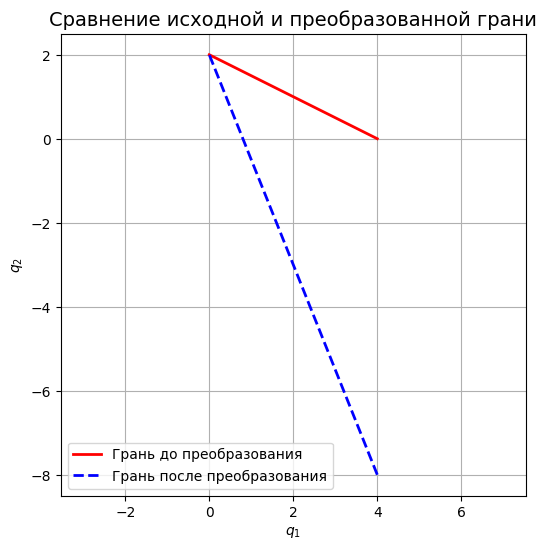

In [27]:
# -----------------------------------------------------------
# Доп. график 2: грань многоугольника до/после преобразования
# -----------------------------------------------------------

import matplotlib.pyplot as plt

# Извлекаем вершины выбранной грани
e = poly.simplices[selected_edge]
p1 = np.array(support[e[0]], dtype=float)
p2 = np.array(support[e[1]], dtype=float)

# Преобразуем вершины через матрицу α
A = np.array(alpha.tolist(), float)

p1_new = A @ p1
p2_new = A @ p2

plt.figure(figsize=(6,6))

# Старая грань
plt.plot([p1[0], p2[0]], [p1[1], p2[1]],
         "r-", lw=2, label="Грань до преобразования")

# Новая грань
plt.plot([p1_new[0], p2_new[0]], [p1_new[1], p2_new[1]],
         "b--", lw=2, label="Грань после преобразования")

plt.title("Сравнение исходной и преобразованной грани", fontsize=14)
plt.xlabel("$q_1$")
plt.ylabel("$q_2$")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.show()

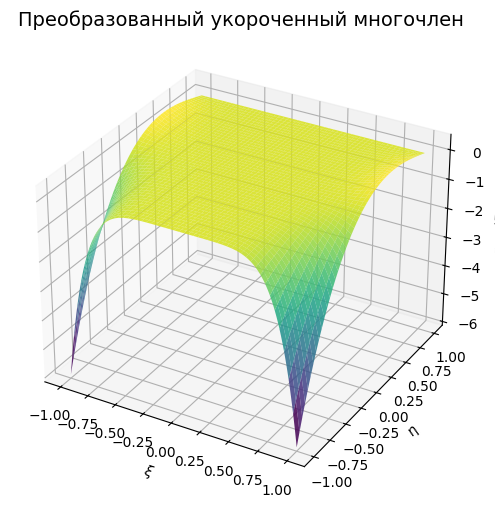

In [28]:
# -----------------------------------------------------------
# Доп. график 3: поверхность преобразованного укороченного многочлена
# -----------------------------------------------------------

from mpl_toolkits.mplot3d import Axes3D

g_new_lambda = sym.lambdify((xi, eta), g_new, "numpy")

xi_vals = np.linspace(-1, 1, 300)
eta_vals = np.linspace(-1, 1, 300)
Xi, Eta = np.meshgrid(xi_vals, eta_vals)

Zg = g_new_lambda(Xi, Eta)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Xi, Eta, Zg, cmap="viridis", alpha=0.85)
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$\eta$")
ax.set_zlabel(r"$g_{\text{new}}(\xi,\eta)$")

ax.set_title("Преобразованный укороченный многочлен", fontsize=14)
plt.show()